## Testing hypothesis 6

---

**_Hypothesis_**: The larger the number of books published for a category, the higher the review score. (marketing strategy, the publishers tend to publish books of the most liked category). The larger the number of books published by publishers, the higher the review score (books published by the most famous publishers are preferred)

   - **Metric**: correlation coefficients, Kolmogorov-Smirnov, Chi-Square, Wilcoxon (for future normalization)

**Missing Values**:

  - `publisher`: remove the entire sample
  - `review/score`: remove the entire sample
  - `categories`: remove the entire sample

**Data Transformation**:

  - `categories`: GroupBy categories.
  - `publisher`: GroupBy publisher.
  - `review/score`: Compute the average review/score for each publisher and category.

---

In [1]:
# Connect to MongoDB

import pymongo

client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['books_joined']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Analysis of `categories`

In [3]:
# Deal with missing values
pipeline_missing = {'$match': {
    'review/score': {'$exists': True, '$ne': 0.0},
    'publisher': {'$exists': True, '$ne': None},
    'categories': {'$exists': True},
}
}

# Compute average rating and number of reviews for each category
pipeline_average_rating = {'$group': {
    '_id': '$categories',
    'avg_score': {'$avg': '$review/score'},
    'count': {'$sum': 1},
    'titles': {'$addToSet': '$Title'}
}
}

# Compute number of different titles for each category
pipeline_project = {'$project': {
    '_id': 0,
    'category': '$_id',
    'avg_score': 1,
    'count': 1,
    'num_titles': {'$size': '$titles'}
}
}

# Remove categories with less than 100 reviews
pipeline_remove = {'$match': {
    'count': {'$gt': 1}
}
}

results_2 = books.aggregate(
    [pipeline_missing, pipeline_average_rating, pipeline_project, pipeline_remove])

df_results_2_category = pd.DataFrame(list(results_2))
df_results_2_category['avg_score_weighted'] = df_results_2_category.avg_score * \
    np.sqrt(df_results_2_category.num_titles)
    
df_results_2_category=df_results_2_category[df_results_2_category['num_titles']>50]

In [4]:
df_results_2_category.sort_values(by='num_titles', ascending = False).head()    

,avg_score,count,category,num_titles,avg_score_weighted
677,4.109408,80725,['Fiction'],11251,435.887963
1038,4.339276,9423,['Religion'],3196,245.313068
780,4.229916,8564,['History'],3038,233.144739
857,4.457688,20219,['Juvenile Fiction'],2954,242.278538
244,4.253363,10258,['Biography & Autobiography'],2533,214.067170


<AxesSubplot: title={'center': 'Number of reviews for each category'}, xlabel='category'>

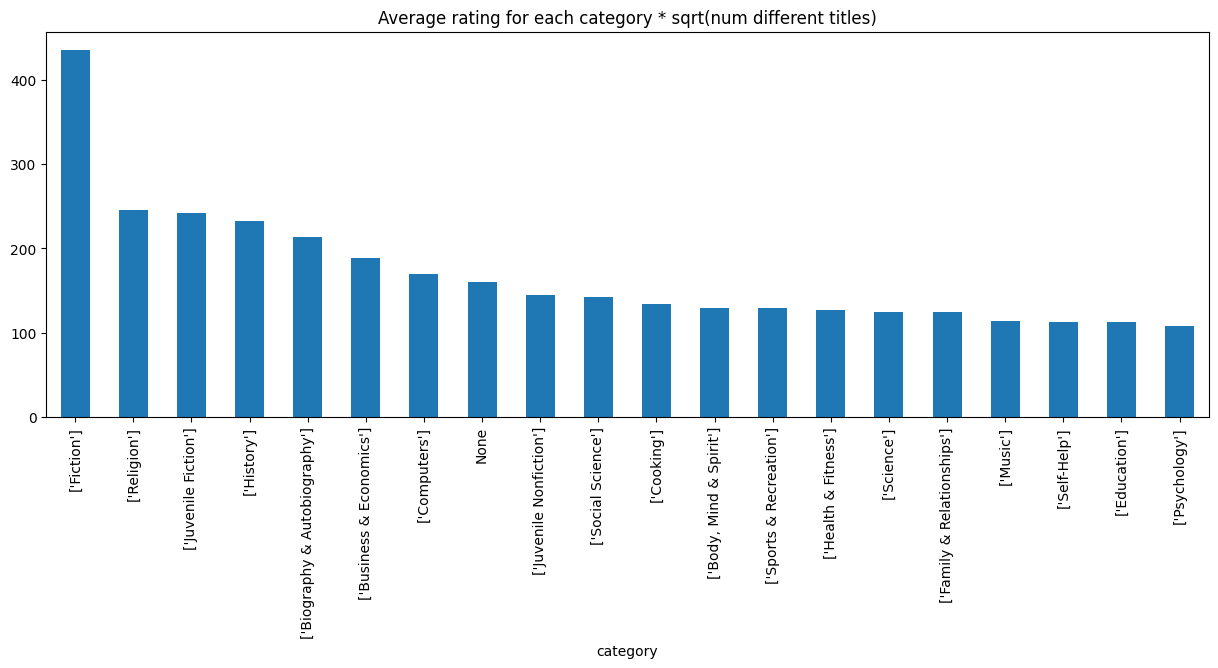

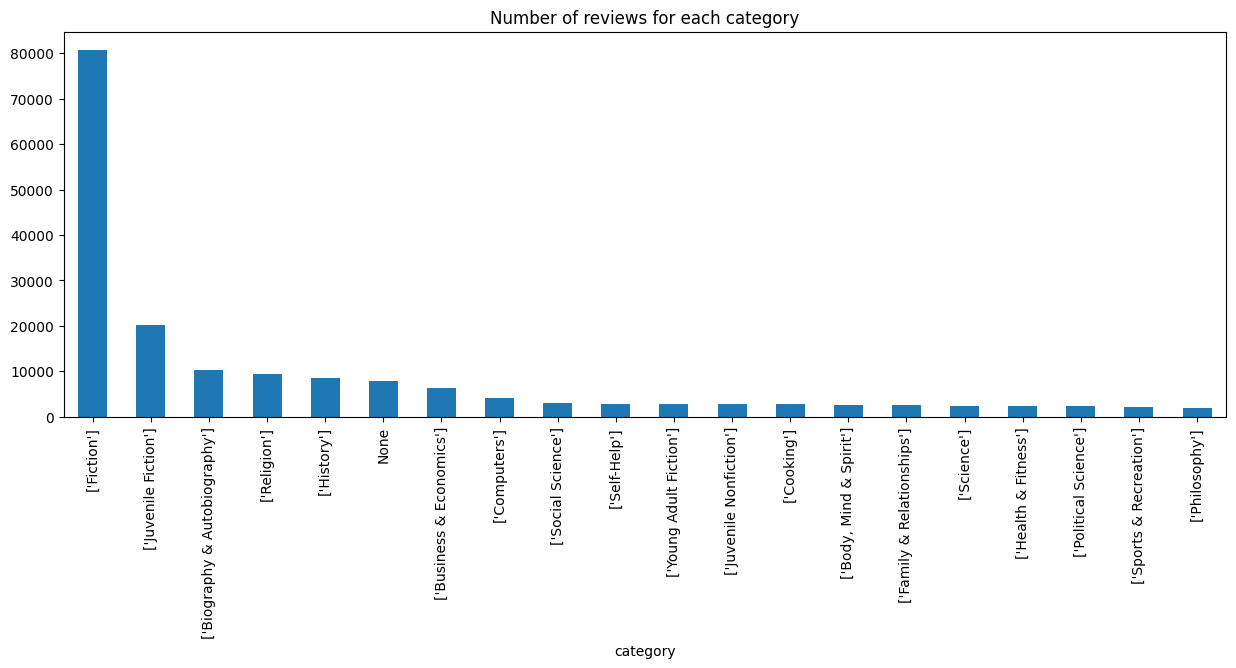

In [5]:
# Analyze the top 20 categories with the highest average rating
df_results_2_category.sort_values(
    by='avg_score_weighted', ascending=False, inplace=True)
df_results_2_category.head(20).plot(x='category', y='avg_score_weighted', kind='bar', figsize=(
    15, 5), xlabel='category', title='Average rating for each category * sqrt(num different titles)', legend=False)

# Analyze the top 20 categories with the highest number of reviews
df_results_2_category.sort_values(by='count', ascending=False, inplace=True)
df_results_2_category.head(20).plot(x='category', y='count', kind='bar', figsize=(
    15, 5), xlabel='category', title='Number of reviews for each category', legend=False)

### Analysis of `publishers`

In [6]:
# Deal with missing values
pipeline_missing = {'$match': {
    'review/score': {'$exists': True, '$ne': 0.0},
    'publisher': {'$exists': True, '$ne': None},
    'categories': {'$exists': True},
}
}

# Compute average rating for each publisher
pipeline_average_rating = {'$group': {
    '_id': '$publisher',
    'avg_score': {'$avg': '$review/score'},
    'count': {'$sum': 1},
    'titles': {'$addToSet': '$Title'}
}
}

# Compute number of different titles for each publisher
pipeline_project = {'$project': {
    '_id': 0,
    'publisher': '$_id',
    'avg_score': 1,
    'count': 1,
    'num_titles': {'$size': '$titles'}
}
}

# Remove publisher with less than 100 reviews
pipeline_remove = {'$match': {
    'count': {'$gt': 1}
}
}

results_2 = books.aggregate(
    [pipeline_missing, pipeline_average_rating, pipeline_project, pipeline_remove])

df_results_2_publisher = pd.DataFrame(list(results_2))
df_results_2_publisher['avg_score_weighted'] = df_results_2_publisher.avg_score * np.sqrt(df_results_2_publisher.num_titles)
df_results_2_publisher=df_results_2_publisher[df_results_2_publisher['num_titles']>20]

In [7]:
df_results_2_publisher.head()

,avg_score,count,publisher,num_titles,avg_score_weighted
0,4.082164,499,"""O'Reilly Media, Inc.""",169,53.068136
2,4.000000,36,*Frommers,22,18.761663
3,4.198276,116,*Howell Book House,61,32.789583
24,4.252747,273,A&C Black,95,41.450653
30,4.106667,75,ABC-CLIO,48,28.451821


<AxesSubplot: title={'center': 'Number of reviews for each publisher'}, xlabel='publisher'>

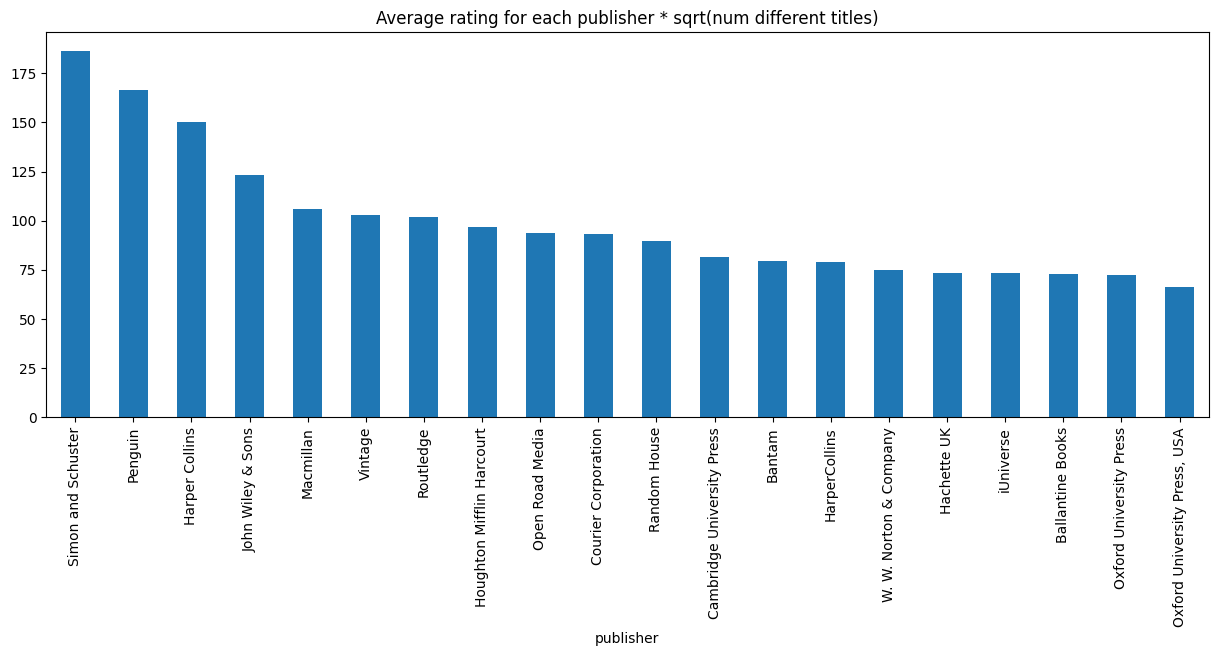

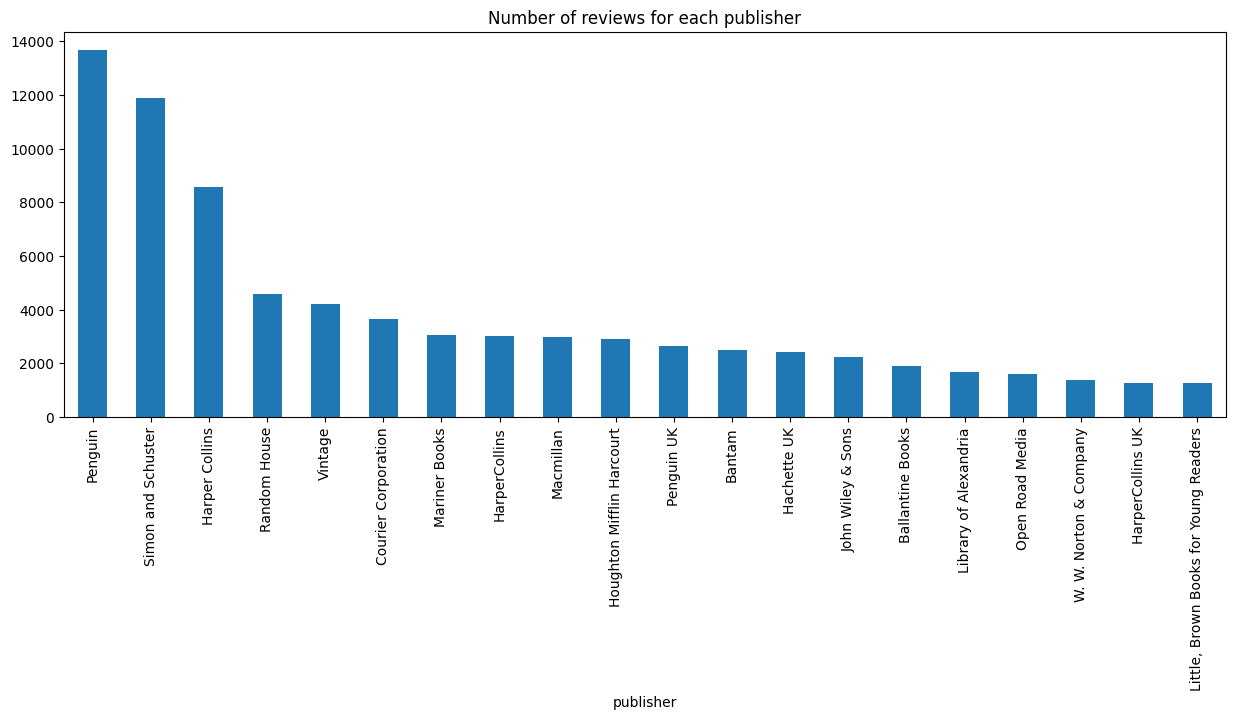

In [8]:
# Analyze the top 20 publishers with the highest average rating
df_results_2_publisher.sort_values(
    by='avg_score_weighted', ascending=False, inplace=True)
df_results_2_publisher.head(20).plot(x='publisher', y='avg_score_weighted', kind='bar', figsize=(
    15, 5), xlabel='publisher', title='Average rating for each publisher * sqrt(num different titles)', legend=False)

# Analyze the top 20 publishers with the highest number of reviews
df_results_2_publisher.sort_values(by='count', ascending=False, inplace=True)
df_results_2_publisher.head(20).plot(x='publisher', y='count', kind='bar', figsize=(
    15, 5), xlabel='publisher', title='Number of reviews for each publisher', legend=False)

## **Correlation** between `avg_rating` and number of `different titles` published

<AxesSubplot: title={'center': 'Average rating for each category respect to number of different titles'}, xlabel='num_titles', ylabel='avg_score'>

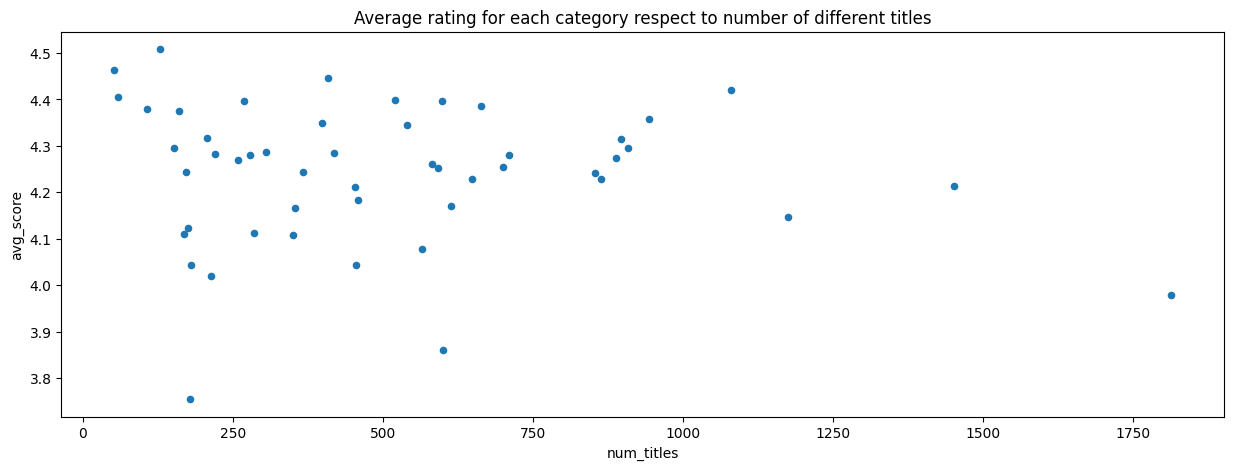

In [9]:
# avg_score for category respect to number of different titles

# Get rid of outliers
df_results_2_category_filtered = df_results_2_category[df_results_2_category.num_titles < 2000]
df_results_2_category_filtered.plot(x='num_titles', y='avg_score', kind='scatter', figsize=(
    15, 5), xlabel='num_titles', title='Average rating for each category respect to number of different titles', legend=False)

In [10]:
from scipy_analyze import *
scipy_analize(df_results_2_category['num_titles'], 'num_titles', df_results_2_category['avg_score'], 'avg_score', [1,2,3,4,5])

The p-value for normality test of num_titles is 3.8931422071036445e-22. The data is not normally distributed.
The p-value for normality test of avg_score is 0.005065311187303777. The data is not normally distributed.
Since at least one of the variables is not normally distributed, we will use Spearman's correlation.
The p-value for correlation value: -0.10710868079289132 between num_titles and avg_score is 0.4320349713084056. The correlation is not significant.
The p-value for Kolmogorov-Smirnov test between num_titles and avg_score is 5.120458204657528e-33. The two variables do not follow the same distribution.
The p-value for Chi-Square test between num_titles and avg_score is 0.2384106459089721. The two variables are independent.
Since at least one of the variables is not normally distributed, we will use Wilcoxon.
The p-value for Wilcoxon test between num_titles and avg_score is 7.547498213151496e-11. The two variables do not have the same mean.


<AxesSubplot: title={'center': 'Average rating for each publisher respect to number of different titles'}, xlabel='num_titles', ylabel='avg_score'>

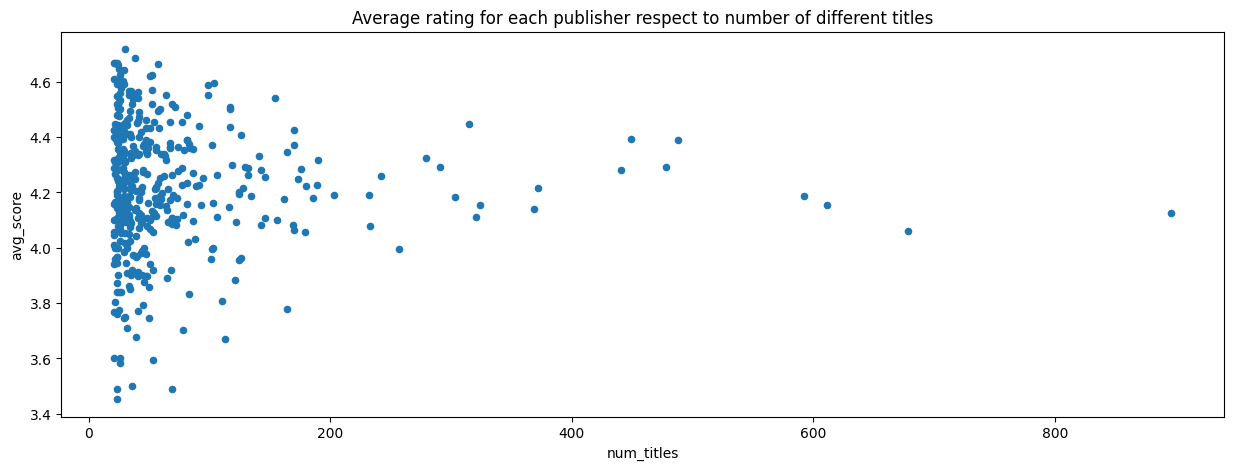

In [11]:
# avg_score for publisher respect to number of different titles
# Get rid of outliers
df_results_2_publisher_filtered = df_results_2_publisher[df_results_2_publisher.num_titles < 1100]
df_results_2_publisher_filtered.plot(x='num_titles', y='avg_score', kind='scatter', figsize=(
    15, 5), xlabel='num_titles', title='Average rating for each publisher respect to number of different titles', legend=False)

In [12]:
from scipy_analyze import *
scipy_analize(df_results_2_publisher['num_titles'], 'num_titles', df_results_2_publisher['avg_score'], 'avg_score', [1,2,3,4,5])

The p-value for normality test of num_titles is 5.240260866668348e-134. The data is not normally distributed.
The p-value for normality test of avg_score is 0.00012196685605120923. The data is not normally distributed.
Since at least one of the variables is not normally distributed, we will use Spearman's correlation.
The p-value for correlation value: -0.02587749867649726 between num_titles and avg_score is 0.5960397488014206. The correlation is not significant.
The p-value for Kolmogorov-Smirnov test between num_titles and avg_score is 6.20974060079165e-253. The two variables do not follow the same distribution.
The p-value for Chi-Square test between num_titles and avg_score is 8.177914579277511e-13. The two variables are not independent.
Since at least one of the variables is not normally distributed, we will use Wilcoxon.
The p-value for Wilcoxon test between num_titles and avg_score is 6.94539166156274e-71. The two variables do not have the same mean.


## **Conclusions**
#### There is no correlation between the number of books published and the average review score, neither for categories nor for publishers.

---

## Further analysis: which are the best publishers?

#### Best = capable of getting very high ratings on their books, in a large number of categories.

In [13]:
# Deal with missing values
pipeline_missing = {'$match': {
    'review/score': {'$exists': True, '$ne': 0},
    'publisher': {'$exists': True, '$ne': None},
    'categories': {'$exists': True},
}
}

# Compute average rating for each tuple category, publisher
pipeline_average_rating = {'$group': {
    '_id': {
        'category': '$categories',
        'publisher': '$publisher',
    },
    'avg_score': {'$avg': '$review/score'},
    'count': {'$sum': 1}
}
}

# Remove avg_score < 4.5
pipeline_remove = {'$match': {
    'avg_score': {'$gte': 4.5}
}}

# Remove categories or publisher with less than 'threshold' reviews
threshold = 0
pipeline_remove_thresh = {'$match': {
    'avg_score/category.count': {'$gte': threshold}
}
}

# Sum the results for each publisher
pipeline_count = {'$group': {
    '_id': '$_id.publisher',
    'total': {'$sum': 1}
}
}

# Pipeline sort
pipeline_sort = {'$sort': {
    'total': -1
}
}

results = books.aggregate([pipeline_missing, pipeline_average_rating, pipeline_remove, pipeline_count, pipeline_sort])

df_results = pd.DataFrame(list(results))

In [14]:
df_results.head()

,_id,total
0,Random House,32
1,HarperCollins,30
2,"Oxford University Press, USA",29
3,HarperCollins UK,29
4,Simon & Schuster,27


<AxesSubplot: title={'center': 'Number of categories with average rating > 4.5 for each publisher'}, xlabel='publisher'>

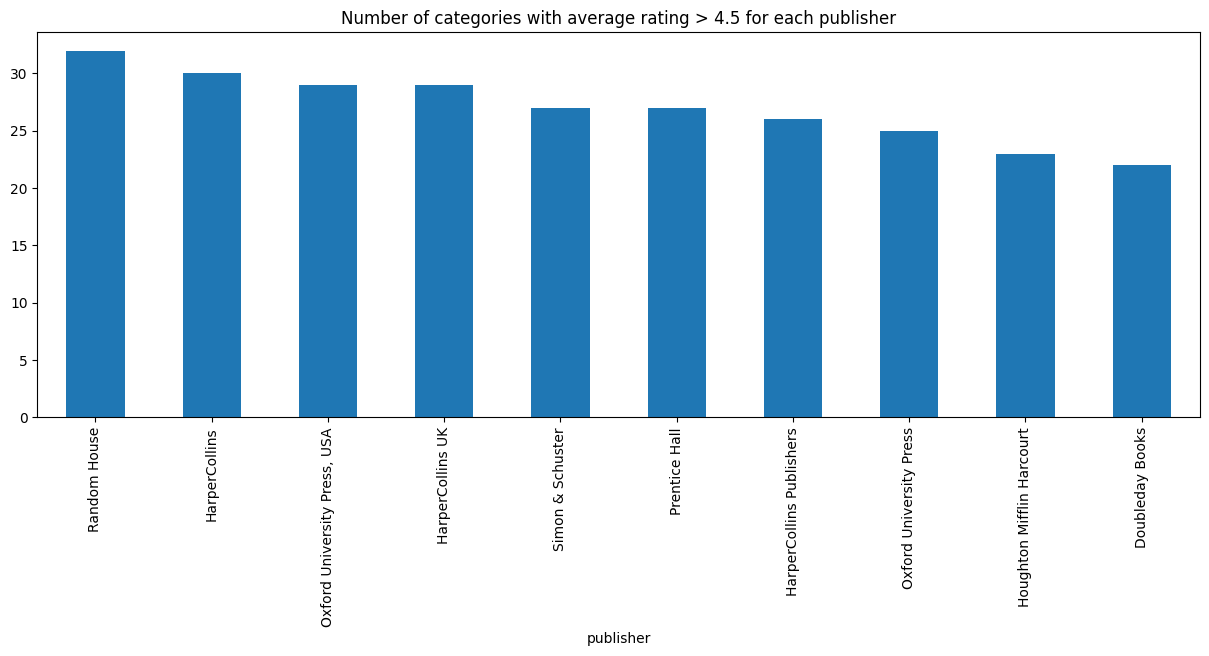

In [15]:
df_results.head(10).plot(x='_id', y='total', kind='bar', figsize=(15, 5), xlabel='publisher',
                         title='Number of categories with average rating > 4.5 for each publisher', legend=False)

---

## Further analysis: In which category there are more best publishers?

#### Best = capable of getting very high ratings on their books.

In [21]:
# Deal with missing values
pipeline_missing = {'$match': {
    'review/score': {'$exists': True, '$ne': 0},
    'publisher': {'$exists': True, '$ne': None},
    'categories': {'$exists': True, '$ne': None},
}
}

# Compute average rating for each tuple category, publisher
pipeline_average_rating = {'$group': {
    '_id': {
        'category': '$categories',
        'publisher': '$publisher',
    },
    'avg_score': {'$avg': '$review/score'},
    'count': {'$sum': 1}
}
}

# Remove avg_score < 4.5
pipeline_remove = {'$match': {
    'avg_score': {'$gte': 4.5}
}}

# Remove categories or publisher with less than 'threshold' reviews
threshold = 0
pipeline_remove_thresh = {'$match': {
    'avg_score/category.count': {'$gte': threshold}
}
}

# Sum the results for each category
pipeline_count = {'$group': {
    '_id': '$_id.category',
    'total': {'$sum': 1}
}
}

# Pipeline sort
pipeline_sort = {'$sort': {
    'total': -1
}
}

results = books.aggregate([pipeline_missing, pipeline_average_rating, pipeline_remove, pipeline_count, pipeline_sort])

df_results = pd.DataFrame(list(results))

In [22]:
df_results.head()

,_id,total
0,['Fiction'],668
1,['Religion'],483
2,['Biography & Autobiography'],457
3,['History'],428
4,['Juvenile Fiction'],381


<AxesSubplot: title={'center': 'Number of publishers with average rating > 4.5 for each category'}, xlabel='category'>

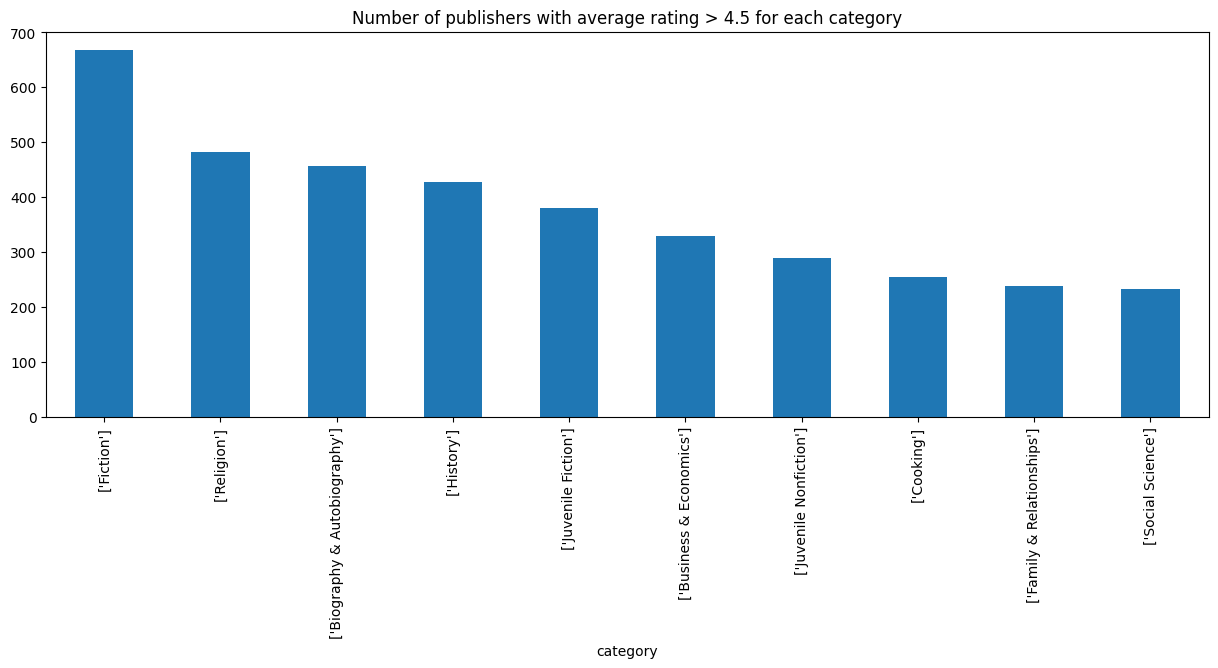

In [23]:
df_results.head(10).plot(x='_id', y='total', kind='bar', figsize=(15, 5), xlabel='category',
                         title='Number of publishers with average rating > 4.5 for each category', legend=False)